In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import copy
from collections import Counter
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

### Methods for experiment

In [3]:
def generate_random_without_constraints(feature_names, data_size):
    '''
    Input: Data, Feature Names, Size of Random Data
    Output: Random Data
    
    Generates random dataset of size data_size
    Random dataset is generated from normal
    distribution with specified high and low values
    '''
    
    df = {}
    for i in range(len(feature_names)):
        df[feature_names[i]] = np.random.normal(size=data_size)
    random_dataset = pd.DataFrame(data=df, columns=feature_names)
    
    return random_dataset

In [4]:
def objective_function(array, label1, label2):
    return abs(1 - float(len(array[array == label1]))/len(array[array == label2]))

In [5]:
def create_summary(X, y, label0, label1, blackbox, epsilon=1e-2, verbose=False):
    
    n_features = X.shape[1]
    i = 1
    while objective_function(y, label0, label1) > epsilon:

        first_label = X[y == label0]
        second_label = X[y == label1]
        if len(first_label) > len(second_label):
            dist = second_label
            not_dist = first_label
        else:
            dist = first_label
            not_dist = second_label

        size = dist.shape[0]
        mean, std = np.mean(dist), np.std(dist)
        shape = np.abs(first_label.shape[0] - second_label.shape[0])
        rnd = np.random.normal(loc=mean, scale=std, size=[shape, n_features])
        X = np.vstack((dist, not_dist[:size, :], rnd[:(X.shape[0] - 2*size)]))

        y = blackbox.predict(X)
        if verbose:
            print 'Epoch: {}\n'.format(i),Counter(y)
        i += 1
    return X

In [6]:
def perform_experiment(X, y, feature_names, blackbox, whitebox, verbose=False):
    
    " X and y corresponds to the training data and labels"
    
    ## Generating random data without constraints
    X_random = generate_random_without_constraints(feature_names, data_size=1000).values
    
    ## Fitting blackbox on the data and predicting labels for random data
    blackbox = copy.deepcopy(blackbox)
    blackbox.fit(X, y)
    if verbose:
        print 'Performance of black box on actual data', blackbox.score(X, y)
    y_random = blackbox.predict(X_random)
    if verbose:
        print 'Initial configuration of random labels: ', Counter(y_random)
    
    ## Whitebox performance on random data
    whitebox = copy.deepcopy(whitebox)
    whitebox.fit(X_random, y_random)
    old_score = whitebox.score(X, y)
    if verbose:
        print 'Performance of whitebox when trained using random data:', old_score
    
    ## Creating new data with equal proportion of both labels
    new_data = create_summary(X_random, y_random, 0, 1, blackbox, verbose=verbose)
    new_labels = blackbox.predict(new_data)
    if verbose:
        print 'Final configuration of random labels: ', Counter(new_labels)
    
    ## Whitebox performance using new data
    whitebox = copy.deepcopy(whitebox)
    whitebox.fit(new_data, new_labels)
    new_score = whitebox.score(X, y)
    if verbose:
        print 'Performance of whitebox when trained using new data:', new_score
    return old_score, new_score

### Breast Cancer Dataset

In [7]:
first_dataset = datasets.load_breast_cancer()
X = first_dataset.data
y = first_dataset.target
feature_names = ['feature{}'.format(i) for i in range(X.shape[1])]
print X.shape, y.shape

(569, 30) (569,)


In [8]:
old_score, new_score = [],[]
for i in range(10):
    
    a, b = perform_experiment(X, y, feature_names, LogisticRegression(), LogisticRegression())
    old_score.append(a)
    new_score.append(b)

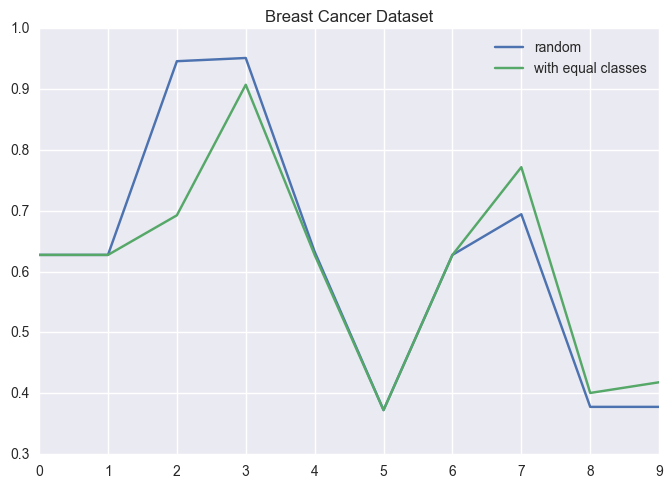

In [9]:
plt.plot(old_score, label='random')
plt.plot(new_score, label='with equal classes')
plt.title('Breast Cancer Dataset')
plt.legend()
plt.show()

### Heart Dataset

In [10]:
second_dataset = pd.read_csv('../data/heart.csv')
y = second_dataset.pop('chd').values
second_dataset['famhist'] = second_dataset['famhist'].map({"Absent": 0, "Present": 1})
feature_names = second_dataset.columns
X = second_dataset.values
print X.shape, y.shape

(462, 9) (462,)


In [11]:
old_score, new_score = [],[]
for i in range(10):
    a, b = perform_experiment(X, y, feature_names, LogisticRegression(), LogisticRegression())
    old_score.append(a)
    new_score.append(b)

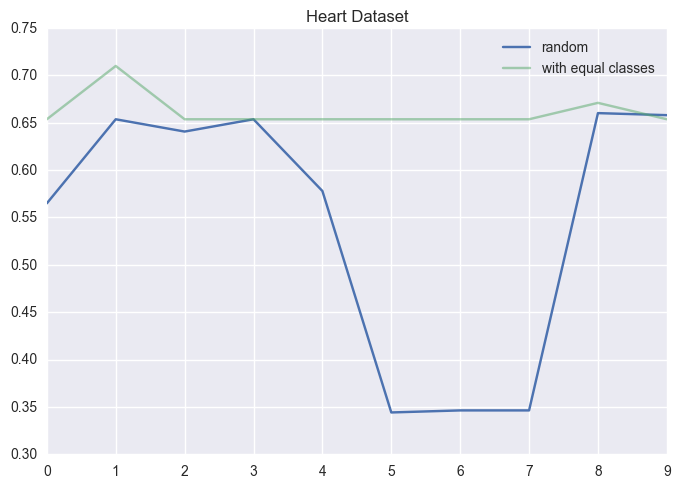

In [12]:
plt.plot(old_score, label='random')
plt.plot(new_score, label='with equal classes',alpha=0.5)
plt.title('Heart Dataset')
plt.legend()
plt.show()